# 2. SHO Fitting in Pytorch

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.nn.Regularization.Regularizers import NegValLoss
# from m3_learning.be.nn import SHO_Model, SHO_NN_Model, SHO_fit_func_nn

# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './../../../Figures/2023_rapid_fitting/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

# import matplotlib.pyplot as plt
# import numpy as np

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# from scipy.signal import resample
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import mean_squared_error

from m3_learning.optimizers.AdaHessian import AdaHessian
# from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
# from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
# from m3_learning.util.preprocessing import global_scaler
# from m3_learning.nn.random import random_seed
# from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
# from m3_learning.be.dataset import BE_Dataset
# from m3_learning.viz.style import set_style

# set_style("printing")

2023-05-01 22:41:53.883698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 22:41:54.002405: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-01 22:41:54.429266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-01 22:41:54.429315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
# import seaborn as sns
# # sns.set_theme(style="whitegrid")

# # Load the example tips dataset
# tips = sns.load_dataset("tips")

# # Draw a nested violinplot and split the violins for easier comparison
# sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
#                split=True, inner="quart", linewidth=1,
#                palette={"Yes": "b", "No": ".85"})
# sns.despine(left=True)

# plt.show()


## Loads Data

In [4]:
# Specify the filename and the path to save the file
filename = 'data_raw.h5'
save_path = './../../../Data/2023_rapid_fitting'


data_path = save_path + '/' + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins = 80,  SHO_fit_func_NN = SHO_fit_func_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data_Reshaped
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ raw_data_resampled
├ Raw_Data-SHO_Fit_000
  --------------------
  ├ Fit
  ├ Guess
  ├ SHO_LSQF
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ comp

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model. 

Note: This uses the results from the least squares fitting LSQF results. 

In [5]:
true = {'fitter' : 'NN',
        'resampled' : False, 
        "label": "NN Fit"}

predicted = {'fitter' : 'LSQF',
             'resampled' : False, 
             "label": "Raw", 
             'scaled': False}

BE_viz = Viz(dataset, printing, verbose=True)


True 


                  Resample = False
                  Raw Format = complex
                  fitter = NN
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
predicted 


                  Resample = False
                  Raw Format = complex
                  fitter = LSQF
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = False
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_7_PyTorch_fit_tester.png
./../../../Figures/2023_rapid_fitting/Figure_7_PyTorch_fit_tester.svg


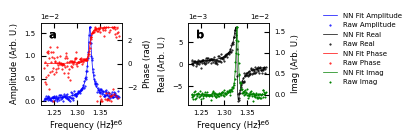

In [6]:
BE_viz.fit_tester(true, predicted, filename="Figure_7_PyTorch_fit_tester")

**Figure 7** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.

## Pytorch Model

### Model Architecture

### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data

(1, 1, 80)
(1, 1, 80)

                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = None
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.png
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.svg


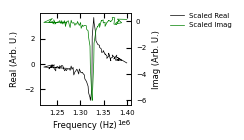

In [7]:
BE_viz = Viz(dataset, printing, verbose=True)


state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : True,
             "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum. 


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.svg


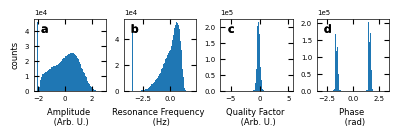

In [8]:
dataset.LSQF_phase_shift = np.pi/2

BE_viz.SHO_hist(dataset.SHO_fit_results(),
                      filename="Figure_9_Phase_Shifted_Scaled_Histograms")

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.  

### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.

In [9]:
random_seed(seed=42)

# instantiate the model
model = SHO_Model(dataset, training=True, model_basename='SHO_Fitter_original_data')

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle = True)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090
(3600, 384, 80)


In [10]:
import torch_optimizer as optml

train = True

if train:
    # fits the model
    model.fit(dataset.X_train, 500, 
              optimizer = "Adam",)
else:
    model.load("/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0414678600463958.pth")

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 1/5, recon loss = 0.08003649
--- 29.555397510528564 seconds ---
epoch : 2/5, recon loss = 0.04564953
--- 28.226529359817505 seconds ---
epoch : 3/5, recon loss = 0.04524387
--- 28.228779315948486 seconds ---
epoch : 4/5, recon loss = 0.04504300
--- 28.2325119972229 seconds ---
epoch : 5/5, recon loss = 0.04492725
--- 28.029280424118042 seconds ---


### Compare SHO and Raw Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.

In [14]:
my_list = ['a','b']
label = ["Scaled " + s for s in my_list]

print(label)

['Scaleda', 'Scaledb']


In [14]:
pred_data, scaled_param, parm = model.predict(X_train)

ind, mse, train_, pred_train = model.get_rankings(X_train, pred_data)

/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/nn.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.zeros_like(torch.tensor(data))


(3600, 384, 80)
(3600, 384, 80)


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/nn.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.zeros_like(torch.tensor(data))
/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:576: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


torch.Size([1382400, 80])


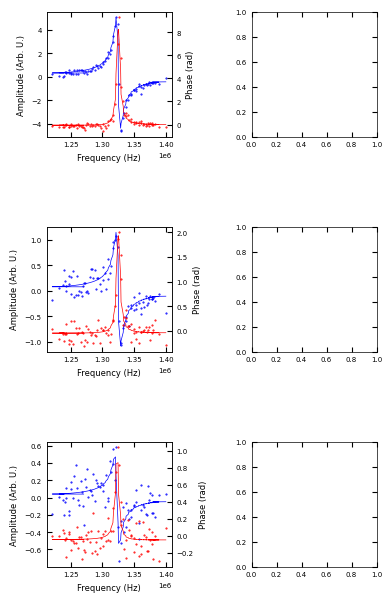

In [20]:
state = {'fitter' : 'LSQF',
            'resampled' : True,
            'scaled' : True,}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1  = BE_viz.validate_nn_best_median_worst(state, X_data, model=model, out_state={"scaled":True}, returns = True)

In [22]:
# something is wrong with the MSE function 

array([0.01142726, 0.04017868, 0.17236288])

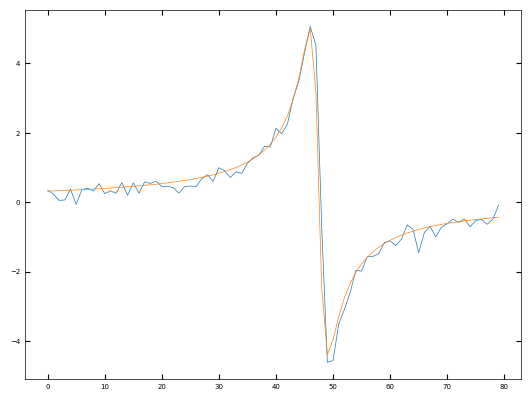

In [30]:
import matplotlib.pyplot as plt

plt.plot(d1[0][0])
plt.plot(d2[0][0])

In [34]:
np.mean((d1[2][0] - d2[2][0])**2) + np.mean((d1[2][1] - d2[2][1])**2)

0.039042148607493325

In [29]:
(np.mean((d1[0][0] - d2[0][0])**2) + np.mean((d1[0][1] - d2[0][1])**2))/2


(3, 2, 80)

In [27]:
np.array(dataset.to_real_imag(dataset.to_complex(pred_train)))[:,0,:] == pred_train[0]

/tmp/ipykernel_161300/3699231420.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(dataset.to_real_imag(dataset.to_complex(pred_train)))[:,0,:] == pred_train[0]


False

In [55]:
X_train.shape

torch.Size([1105920, 80, 2])

In [54]:
pred_data.shape

torch.Size([1105920, 80, 2])

In [57]:
train_.shape

(3, 2, 80)

In [54]:
mse

array([0.01144022, 0.04046215, 0.22722964], dtype=float32)

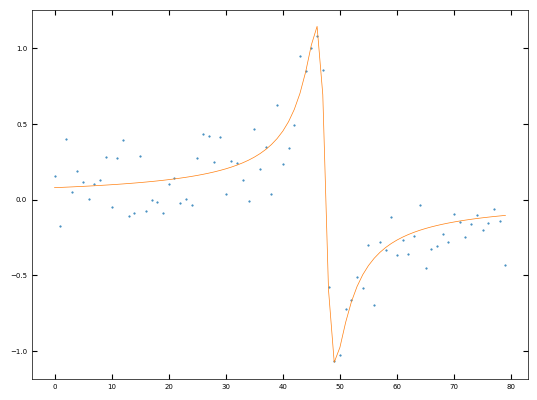

In [55]:
import matplotlib.pyplot as plt


plt.plot(d1[1][0], 'o', label = 'Predicted')
plt.plot(d2[1][0], '-', label = 'Predicted')

### Statistics of the Results for Training, Validation, and Entire Dataset

In [11]:
# dataset.LSQF_phase_shift = 0

# state = {'fitter' : 'LSQF',
#              'resampled' : True,
#              'scaled' : False, 
#              "measurement_state" : "complex"}

# BE_viz.set_attributes(**state)

# self = dataset

# fit_results = self.raw_spectra(fit_results = self.SHO_fit_results())

# fit_results = self.raw_data_scaler.transform(fit_results)

# fit_results = self.to_real_imag(fit_results)

# state = {'fitter' : 'LSQF',
#              'resampled' : True,
#              'scaled' : True, 
#              "measurement_state" : "complex"}

# BE_viz.set_attributes(**state)

# raw = self.raw_spectra()

/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:417: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array(data)
/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:417: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


(3600, 384, 80)


In [ ]:
# fit_results[0].shape

In [ ]:
# from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(fit_results[0].reshape(-1,80), raw[0].reshape(-1,80)) + mean_squared_error(fit_results[1].reshape(-1,80), raw[1].reshape(-1,80))

# mse /=2

In [ ]:
# import matplotlib.pyplot as plt

# i = np.random.randint(0, len(raw[0]))

# plt.plot(raw[0].reshape(-1,80)[i])
# plt.plot(fit_results[0].reshape(-1,80)[i])

### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.

In [12]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)

(3600, 384, 80)
Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 2.430868 ± 0.934787
Average execution time per iteration (ms): 0.002431 ± 0.000935
Total execution time (s): 3.36 


### Visualization of the Distribution of the NN Fit Results

It is useful to check the distribution of the scaled and unscaled fit results for the entire dataset, this will also allow us to add a correction for a phase shift (if necessary).

#### Unscaled Histograms of Neural Network Fit Results

In [79]:
# dataset.NN_phase_shift = 3*np.pi/2

# pred_data, scaled_param, parm = model.predict(X_train)

/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/nn.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.zeros_like(torch.tensor(data))



                  Resample = True
                  Raw Format = magnitude spectrum
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = complex
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 0
                  NN Phase Shift = 4.71238898038469
                  
./../../../Figures/2023_rapid_fitting/Figure_10_NN_Unscaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_10_NN_Unscaled_Histograms.svg


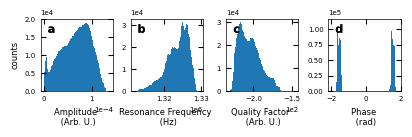

In [31]:
# BE_viz.SHO_hist(parm, filename = "Figure_10_NN_Unscaled_Histograms")

In [13]:
pred_data, scaled_param, parm = model.predict(X_data)

/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/nn.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.zeros_like(torch.tensor(data))


**Figure 10** Calculated fitting parameters from the neural network.  Histograms of the unscaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.  

#### Scaled Histograms of Neural Network Fit Results


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_11_NN_Scaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_11_NN_Scaled_Histograms.svg


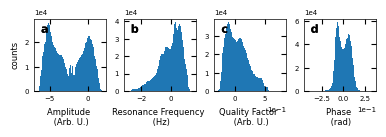

In [16]:
BE_viz.SHO_hist(scaled_param, filename = "Figure_11_NN_Scaled_Histograms")


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = pixels
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = None
                  
./../../../Figures/2023_rapid_fitting/Figure_10_NN_Unscaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_10_NN_Unscaled_Histograms.svg


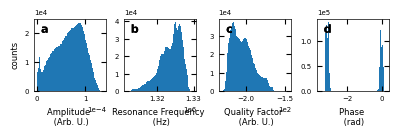

In [17]:
BE_viz.SHO_hist(parm, filename = "Figure_10_NN_Unscaled_Histograms")

In [23]:
self = dataset

state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : True, 
             "measurement_state" : "complex"}

BE_viz.set_attributes(**state)

raw = self.raw_spectra()



(3600, 384, 80)


In [24]:
3600*384

1382400

In [20]:
from m3_learning.be.nn import SHO_fit_func_nn

out = SHO_fit_func_nn(parm, dataset.resampled_freq)

out = dataset.raw_data_scaler.transform(out)

out = dataset.to_real_imag(out)


In [21]:
out[0].shape

torch.Size([1382400, 80])

In [25]:
dataset.NN_phase_shift = 0

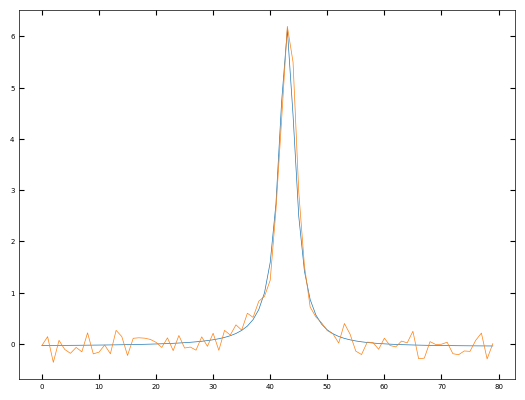

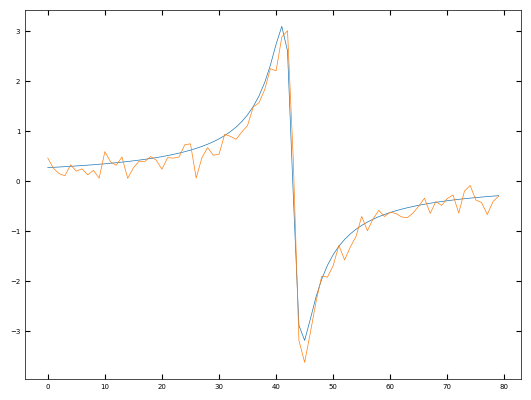

In [38]:
import matplotlib.pyplot as plt

i = np.random.randint(0, len(raw[0]))

# plt.plot(out[0].reshape(-1,80)[i])
plt.plot(out[1].reshape(-1,80)[i])
plt.plot(raw[1].reshape(-1,80)[i])

plt.figure()
plt.plot(out[0].reshape(-1,80)[i])
plt.plot(raw[0].reshape(-1,80)[i])

**Figure 11** Calculated fitting parameters from the neural network.  Histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.  

### Model Validation

It is helpful to view reconstructions of the data from the training and validation datasets. This ensures that the model is doing a good job of fitting the data.

#### Random Training Data Fit

./../../../Figures/2023_rapid_fitting/Figure_11_NN_Validation_example_training.png
./../../../Figures/2023_rapid_fitting/Figure_11_NN_Validation_example_training.svg


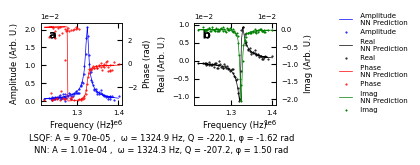

In [15]:
BE_viz.nn_validation(model, X_train, 
                     filename = "Figure_11_NN_Validation_example_training", 
                     SHO_results = y_train)

**Figure 11** A random reconstruction of the neural network fits for the training dataset

In [ ]:
BE_viz.nn_validation(model, X_test, 
                     filename = "Figure_12_NN_Validation_example_test", 
                     SHO_results = y_test)

**Figure 12** A random reconstruction of the neural network fits for the training dataset

In [ ]:
state = {"raw_format": "magnitude spectrum",}

BE_viz.set_attributes(**state)

BE_viz.best_median_worst_reconstructions(model, X_data, SHO_values=Y_data, filename="Figure_13_NN_Best_Median_Worst_Reconstructions_Training")


In [ ]:
BE_viz.best_median_worst_reconstructions(model, X_test, SHO_values=y_test, filename="Figure 14_NN_Best_Median_Worst_Reconstructions_Testing")


Overall, the fit results are excellent for both the training and validation datasets.

In [ ]:
import pandas as pd

df = pd.DataFrame()





true = scaled_param
compare = dataset.SHO_fit_results().reshape(-1,4)

true_df = pd.DataFrame(true, columns=['Amplitude', 'Resonance', 'Q-Factor', 'Phase'])
predicted_df = pd.DataFrame(compare, columns = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase'])

df = pd.concat((true_df, predicted_df))

# df = pd.DataFrame(np.vstack((true, compare)))

names = [true, compare]
names_str = ['SHO', 'NN']
labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

for j, name in enumerate(names):
    for i, label in enumerate(labels):
        dict_ = {"value": name[:,i],
                 "parameter": np.repeat(label, name.shape[0]),
                 "dataset": np.repeat(names_str[j], name.shape[0])}
        
        df = pd.concat((df, pd.DataFrame(dict_)))


In [ ]:
import pandas as pd
impoet


state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : True, 
             "measurement_state" : "complex"}

BE_viz.set_attributes(**state)


true = scaled_param
compare = dataset.SHO_fit_results().reshape(-1,4)

# build a dictionary:
DataNames = [true, compare]
labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']
names_str = ['NN', 'SHO']

df = pd.DataFrame()

for i, data in enumerate(DataNames):
    for j, signal in enumerate(labels):
        dict_ = {"value": data[:,j],
               "parameter": np.repeat(signal, data.shape[0]),
               "dataset": np.repeat(names_str[i], data.shape[0])}
        
        df = pd.concat((df, pd.DataFrame(dict_)))

In [ ]:
import seaborn as sns
sns.violinplot(data=df, x='parameter', y='value', hue='dataset', split=True)

In [ ]:
import seaborn as sns
import pandas as pd

# Create a random dataset with two categories
data = pd.DataFrame({
    'category': ['left'] * 100 + ['right'] * 100,
    'value': np.concatenate([np.random.randn(100), np.random.randn(100) + 2])
})

# Create a violin plot with left and right categories
sns.violinplot(x='category', y='value', hue='category', data=data, split=True)


In [ ]:
df.head()

In [ ]:
df.head()

## Comparison of NN and LSQF Results

It is useful to compare the NN and LSQF results. While generally, the LSQF results might be considered the ground truth, this is not really the case. It is unclear which fitting method is actually more precise and accurate. We conjecture through this analysis that the neural network is actually a more accurate and precise fitting method. 

This section will help to make this case. 

In [ ]:
state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : False, 
             "raw_format": "magnitude spectrum",}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results = dataset.SHO_fit_results())

state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : False, 
             "raw_format": "magnitude spectrum",}

BE_viz.set_attributes(**state)

raw_spectra = dataset.raw_spectra()

# ind, mse = BE_viz.best_median_worst_fit_comparison(LSQF_results, raw_spectra, 1, 1)

In [ ]:
BE_viz.best_median_worst_fit_comparison()

In [ ]:
self = BE_viz

# for the SHO curves it makes sense to determine the error based on the normalized fit results in complex form. 
state = {'fitter' : 'LSQF',
        'resampled' : False,
        'scaled' : True, 
        "raw_format": "complex",}

self.set_attributes(**state)

fit_results_compare = self.dataset.raw_spectra(fit_results = self.dataset.SHO_fit_results())

raw_SHO = self.dataset.raw_spectra()

index1, mse1, d1, d2 = SHO_Model.get_rankings(raw_SHO, fit_results_compare, n = 1)

In [ ]:
index1

In [ ]:
a = raw_SHO[0].reshape(-1, 165)[745386]
b = np.array(fit_results_compare[0].reshape(-1, 165)[745386])

a1 = raw_SHO[1].reshape(-1, 165)[745386]
b1 = np.array(fit_results_compare[1].reshape(-1, 165)[745386])

In [ ]:
(np.mean((a-b)**2) + np.mean((a1-b1)**2))/2

In [ ]:
X_data.shape

In [ ]:
dataset.resampled_freq.shape

In [ ]:
plt.plot(dataset.frequency_bin)
plt.plot(dataset.resampled_freq, 'o')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(
    X_data[745386,:,0])
# plt.plot(dataset.frequency_bin, a)
# plt.plot(dataset.frequency_bin, b)

In [ ]:
state = {'fitter' : 'LSQF',
             'resampled' : True,
             'scaled' : True, 
             "raw_format": "complex",}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results = dataset.SHO_fit_results())

In [ ]:
np.array(d1).shape

In [ ]:
d1[1][0].shape

In [ ]:
plt.plot(d1[0][0])
plt.plot(d1[1][0])
mse1[0]

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
index, mse, c1, c2 = SHO_Model.get_rankings(LSQF_results, raw_spectra, n= 1, curves=True)

In [ ]:
c1.shape

In [ ]:
plt.plot(c1[0,0])
plt.plot(c2[0,0] , 'o')

In [ ]:
plt.plot(c1[2,:,1])
plt.plot(c2[2,:,1] , 'o')

In [ ]:
[tensor.numpy() for tensor in LSQF_results]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(LSQF_results[0][100,100,:])
plt.plot(raw_spectra[0][100,100,:])


In [ ]:
[0### LSQF NN compairison resonstruction

### LSQF NN comapairison distributions

### LSQF NN comparison movies.'